In [1]:
import os
import copy
import glob
import json

import numpy as np
import torch

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

mpl.backend_bases.register_backend("pdf", FigureCanvasPgf)
mpl.use("pgf")
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Matplotlib plotting options
plt.style.use("seaborn-paper")
plt.rcParams.update({
    "axes.labelsize": 22,               # label size (x- and y-axis)
    "axes.titlesize": 26,               # title size on (most) axes
    "figure.titlesize": 26,             # title size for fig.sup_title()
    "legend.fontsize": "x-large",       # font size for legend
    "lines.markersize": 6,              # marker size for points and lines
    "lines.markeredgewidth": 2,         # marker edgewidth for points
    "xtick.labelsize": 18,              # label size for x-ticks 
    "ytick.labelsize": 18,              # label size for y-ticks

    "font.family": "serif",             # use serif/main font for text elements
    "text.usetex": True,                # use inline math for ticks
    "pgf.rcfonts": False,               # don't setup fonts from rc params
    "pgf.preamble": [
        # Syling
        r"\usepackage{color}",          # special colors
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r"\usepackage{bm}",             # bold text

        # Math
        r"\usepackage{xfrac}",          # side fractions
        r"\usepackage{amsthm}",         # theorems
        r"\usepackage{amsmath}",        # misc math
        r"\usepackage{amssymb}",        # blackboard math symbols
        r"\usepackage{mathtools}",      # enhance the appearance of math
    ],
})

from profit.models.torch import SequenceOracle, SequenceGPR
from profit.utils.data_utils.tokenizers import AminoAcidTokenizer
from profit.utils.data_utils.serializers import LMDBSerializer

Using TensorFlow backend.


In [2]:
# Preprocess + load the dataset
dataset = LMDBSerializer.load("../../data/3gb1/processed/lstm_fitness/primary_encoding=aa20.mdb")
Xaa = dataset[:]["arr_0"].long()
_labels = dataset[:]["arr_1"].view(-1)

# Determine vocab and sequence length
tokenizer = AminoAcidTokenizer("aa20")
vocab_size = tokenizer.vocab_size
seqlen = Xaa.size(1)

# Convert to onehot
X = torch.zeros(*Xaa.size(), vocab_size)
X.scatter_(2, torch.unsqueeze(Xaa, 2), 1)
X.size()

torch.Size([570, 56, 20])

In [3]:
paths = sorted(glob.glob("../../bin/3gb1/tmp/oracle/*/E*"))
paths

['../../bin/3gb1/tmp/oracle/2020-Jun-10-17:49:58/E0003.pt',
 '../../bin/3gb1/tmp/oracle/2020-Jun-10-18:00:08/E0004.pt',
 '../../bin/3gb1/tmp/oracle/2020-Jun-10-18:01:17/E0017.pt',
 '../../bin/3gb1/tmp/oracle/2020-Jun-10-18:01:57/E0042.pt',
 '../../bin/3gb1/tmp/oracle/2020-Jun-10-18:04:13/E0012.pt',
 '../../bin/3gb1/tmp/oracle/2020-Jun-10-18:05:53/E0030.pt',
 '../../bin/3gb1/tmp/oracle/2020-Jun-10-18:08:15/E0004.pt']

In [4]:
oracle_stump = SequenceOracle(seqlen, vocab_size, hidden_size=5, out_size=1)
oracle_stump.load_state_dict(torch.load(paths[-4]))
oracle_stump

SequenceOracle(
  (fc1): Linear(in_features=1120, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [5]:
oracle_stump.eval()
with torch.no_grad():
    oracle_pred = oracle_stump(X).squeeze()
oracle_pred.shape

torch.Size([570])

In [6]:
idx = torch.sort(oracle_pred).indices[-10:]
oracle_pred[idx], _labels[idx]

(tensor([1.0943, 1.1081, 1.2220, 1.2579, 1.3318, 1.3434, 1.4096, 1.5657, 1.6550,
         1.6816]),
 tensor([0.6578, 0.3900, 1.2266, 1.6815, 0.7183, 2.4872, 0.1649, 4.9163, 5.0733,
         3.1087]))

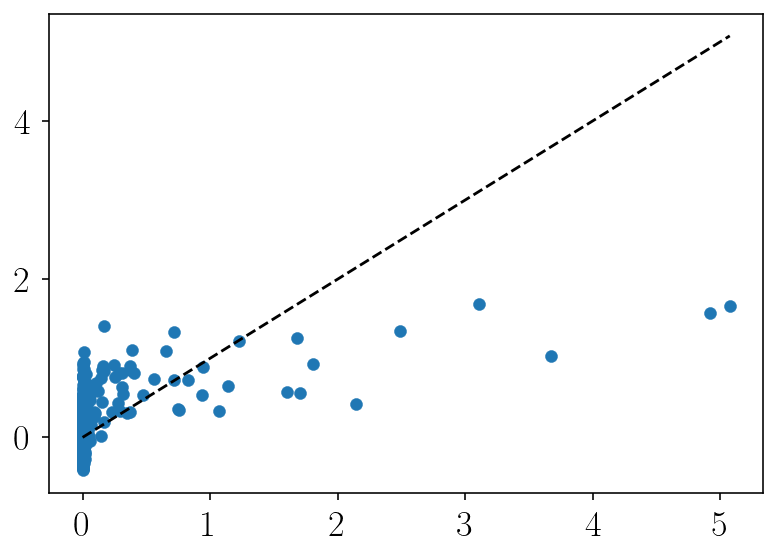

In [7]:
plt.scatter(_labels, oracle_pred)
xy = np.linspace(_labels.min(), _labels.max())
plt.plot(xy, xy, "--", c="black")

In [8]:
# Load full testing dataset
from examples.gb1.data import load_variants

In [9]:
test = load_variants("lstm", "Fitness", vocab="aa20")

Loading preprocessed data from cache `data/3gb1/processed/lstm_fitness/variants_encoding=aa20.mdb`


In [10]:
Xaa_test = test[:]["arr_0"].long()

# Determine vocab and sequence length
tokenizer = AminoAcidTokenizer("aa20")
vocab_size = tokenizer.vocab_size
seqlen = Xaa_test.size(1)

# Convert to onehot
X_test = torch.zeros(*Xaa_test.size(), vocab_size)
X_test.scatter_(2, torch.unsqueeze(Xaa_test, 2), 1)
X_test.size()

torch.Size([160000, 56, 20])

In [11]:
oracle_stump.eval()
with torch.no_grad():
    oracle_test_pred = oracle_stump(X_test).squeeze()
oracle_test_pred.shape

torch.Size([160000])

In [12]:
idx = torch.sort(oracle_test_pred).indices[-10:]
oracle_test_pred[idx]

tensor([1.7013, 1.7110, 1.7157, 1.7253, 1.7521, 1.7780, 1.7852, 1.7948, 1.8106,
        1.8203])

In [13]:
paths = sorted(glob.glob("../../bin/3gb1/gpr/*"))
metadata = ["all", "g-mean", "l-mean", "g-median", "l-median", "g-zero"]
gpr_paths = dict(zip(metadata, paths))
all_gps = {desc: torch.load(path) for desc, path in gpr_paths.items()}
all_gps

{'all': <profit.models.torch.gpr.SequenceGPR at 0x64fef0390>,
 'g-mean': <profit.models.torch.gpr.SequenceGPR at 0x64fef0350>,
 'l-mean': <profit.models.torch.gpr.SequenceGPR at 0x64fef0a10>,
 'g-median': <profit.models.torch.gpr.SequenceGPR at 0x64fef0a50>,
 'l-median': <profit.models.torch.gpr.SequenceGPR at 0x64fef0a90>,
 'g-zero': <profit.models.torch.gpr.SequenceGPR at 0x64fef0ad0>}

In [17]:
Xaa_test_iter = Xaa_test.view(160, 1000, -1)
Xaa_test_iter.shape

torch.Size([160, 1000, 56])

In [18]:
gp = all_gps["all"]
gp_test_pred = []
for Xaa_test in Xaa_test_iter:
    gp_test_pred.append(gp.predict(Xaa_test, return_std=False).squeeze())

ValueError: only one element tensors can be converted to Python scalars

In [24]:
gp_test_pred = torch.Tensor(np.array([scores.numpy() for scores in gp_test_pred]).flatten())

In [25]:
# idx = torch.sort(gp_test_pred).indices[-10:]
gp_test_pred[idx]

tensor([1.1479, 1.8563, 1.9064, 1.1838, 2.1656, 1.4352, 2.1930, 1.5508, 1.3070,
        1.2081])

In [26]:
idx = torch.sort(gp_test_pred).indices[-10:]
gp_test_pred[idx]

tensor([3.1373, 3.1879, 3.3027, 3.3207, 3.3859, 3.4492, 3.4789, 3.7716, 4.2519,
        4.4255])

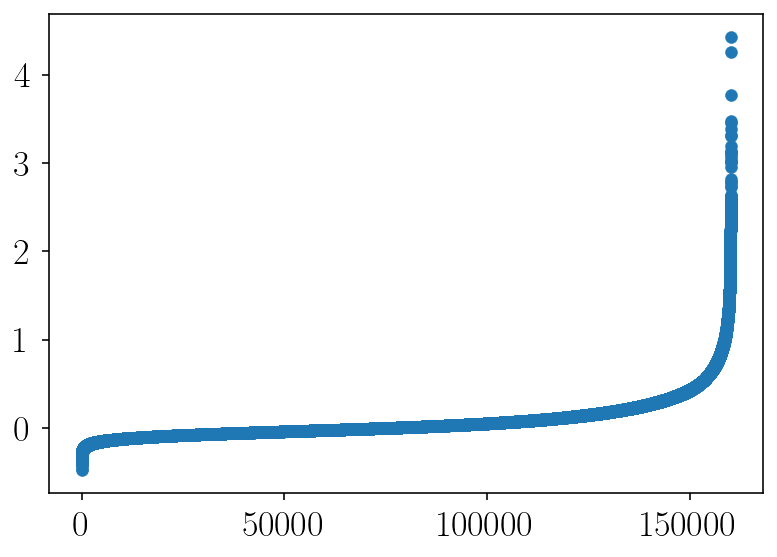

In [27]:
plt.scatter(np.arange(len(gp_test_pred)), torch.sort(gp_test_pred).values)

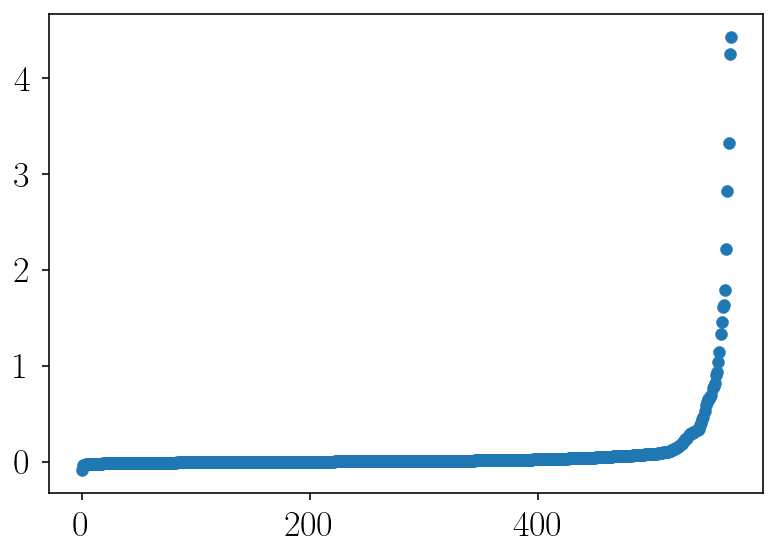

In [30]:
gp_train_pred = gp.predict(Xaa).squeeze()
plt.scatter(np.arange(len(gp_train_pred)), torch.sort(gp_train_pred).values)

In [31]:
idx = torch.sort(gp_train_pred).indices[-10:]
gp_train_pred[idx]

tensor([1.3298, 1.4522, 1.6066, 1.6298, 1.7879, 2.2132, 2.8175, 3.3207, 4.2519,
        4.4255])